# 0.0 Imports

In [116]:
import math
import inflection
import datetime


import pandas   as pd
import numpy    as np
import seaborn  as sns



from matplotlib         import pyplot as plt
from IPython.display    import Image



## 0.1 Helper Functions

## 0.2 Loading data

In [117]:
df_sales_raw = pd.read_csv('datasets/train.csv', low_memory=False)
df_store_raw = pd.read_csv('datasets/store.csv', low_memory=False)

# merge

df_raw = pd.merge(df_sales_raw, df_store_raw, how='left', on='Store')

In [118]:
df_raw.sample()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
894886,327,6,2013-04-20,6145,787,1,0,0,0,c,c,1390.0,12.0,2004.0,0,NaN,NaN,NaN


# 1.0 Descrição dos dados

In [119]:
df1 = df_raw.copy()

## 1.1 Rename Columns

In [120]:
cols_old = ['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo', 'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek', 'Promo2SinceYear', 'PromoInterval']

snakecase = lambda x: inflection.underscore( x )

cols_new = list (map (snakecase, cols_old))

#
df1.columns = cols_new

## 1.2 Data Dimensions

In [121]:
print('Number of Rows: {}'.format(df1.shape[0]))
print('Number of Columns: {}'.format(df1.shape[1]))

Number of Rows: 1017209
Number of Columns: 18


## 1.3 Data Types

In [122]:
df1['date'] = pd.to_datetime( df1['date'])
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
dtype: object

## 1.4 Check NA

In [123]:
df1.isna().sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

## 1.5 Fillout NA

In [124]:
# competition_distance

df1['competition_distance'] = df1['competition_distance'].apply(lambda x: 200000.0 if math.isnan ( x ) else x)

# competition_open_since_month

df1['competition_open_since_month'] = df1.apply( lambda x: x['date'].month if math.isnan(x['competition_open_since_month']) else x['competition_open_since_month'], axis=1) 

# competition_open_since_year

df1['competition_open_since_year'] = df1.apply( lambda x: x['date'].year if math.isnan(x['competition_open_since_year']) else x['competition_open_since_year'], axis=1) 

# promo2_since_week 

df1['promo2_since_week'] = df1.apply( lambda x: x['date'].week if math.isnan(x['promo2_since_week']) else x['promo2_since_week'], axis=1) 

# promo2_since_year

df1['promo2_since_year'] = df1.apply( lambda x: x['date'].year if math.isnan(x['promo2_since_year']) else x['promo2_since_year'], axis=1) 

# promo_interval

month_map = {1: 'Jan', 2: 'Fev', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun', 7: 'Jul', 8: 'Aug', 9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dec'}

df1['promo_interval'].fillna(0, inplace=True)

df1['month_map'] = df1['date'].dt.month.map( month_map)

df1['is_promo'] = df1[['promo_interval', 'month_map']].apply( lambda x: 0 if x['promo_interval'] == 0 else 1 if x['month_map'] in x['promo_interval'].split( ',') else 0, axis=1)


C:\Users\Ian\AppData\Local\Temp\ipykernel_10040\166281126.py:25: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df1['promo_interval'].fillna(0, inplace=True)


In [125]:
df1.isna().sum()

store                           0
day_of_week                     0
date                            0
sales                           0
customers                       0
open                            0
promo                           0
state_holiday                   0
school_holiday                  0
store_type                      0
assortment                      0
competition_distance            0
competition_open_since_month    0
competition_open_since_year     0
promo2                          0
promo2_since_week               0
promo2_since_year               0
promo_interval                  0
month_map                       0
is_promo                        0
dtype: int64

In [126]:
df1.sample(5).T

,115864,334351,790279,440661,177385
store,1020,875,530,1022,101
day_of_week,7,4,2,1,7
date,2015-04-19 00:00:00,2014-09-18 00:00:00,2013-07-23 00:00:00,2014-06-02 00:00:00,2015-02-22 00:00:00
sales,0,4913,8152,12825,0
customers,0,485,1402,1179,0
open,0,1,1,1,0
promo,0,1,0,1,0
state_holiday,0,0,0,0,0
school_holiday,0,0,1,0,0
store_type,a,d,a,a,d


In [127]:
df1.isna().sum()

store                           0
day_of_week                     0
date                            0
sales                           0
customers                       0
open                            0
promo                           0
state_holiday                   0
school_holiday                  0
store_type                      0
assortment                      0
competition_distance            0
competition_open_since_month    0
competition_open_since_year     0
promo2                          0
promo2_since_week               0
promo2_since_year               0
promo_interval                  0
month_map                       0
is_promo                        0
dtype: int64

## 1.6 Change Types

In [128]:
df1['competition_open_since_month'] = df1['competition_open_since_month'].astype( int )
df1['competition_open_since_year'] = df1['competition_open_since_year'].astype( int )

df1['promo2_since_week'] = df1['promo2_since_week'].astype( int )
df1['promo2_since_year'] = df1['promo2_since_year'].astype( int )

## 1.7 Descriptive Statistical

In [129]:
num_attributes = df1.select_dtypes( include=['int64', 'float64'])
cat_attributes = df1.select_dtypes( exclude=['int64', 'float64', 'datetime64[ns]'])

In [130]:
cat_attributes.sample(2)

,state_holiday,store_type,assortment,promo_interval,month_map
237620,0,d,c,0,Dec
822093,0,a,c,0,Jun


### 1.7.1 Numerical Attributes

In [131]:
# Central Tendency - mean, median

ct1 = pd.DataFrame (num_attributes.apply(np.mean)).T
ct2 = pd.DataFrame (num_attributes.apply(np.median)).T

# Dispersion - std, min, max, range, skew, kurtosis

d1 = pd.DataFrame (num_attributes.apply(np.std)).T
d2 = pd.DataFrame (num_attributes.apply(min)).T
d3 = pd.DataFrame (num_attributes.apply(max)).T
d4= pd.DataFrame (num_attributes.apply(lambda x: x.max() - x.min())).T
d5= pd.DataFrame (num_attributes.apply(lambda x: x.skew())).T
d6= pd.DataFrame (num_attributes.apply(lambda x: x.kurtosis())).T

# concatenate
m = pd.concat([d2 ,d3 ,d4 , ct1 ,ct2 , d1 , d5 , d6]).T.reset_index()
m. columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis' ]

m

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,store,1.0,1115.0,1114.0,558.429727,558.0,321.908493,-0.000955,-1.200524
1,day_of_week,1.0,7.0,6.0,3.998341,4.0,1.997390,0.001593,-1.246873
2,sales,0.0,41551.0,41551.0,5773.818972,5744.0,3849.924283,0.641460,1.778375
3,customers,0.0,7388.0,7388.0,633.145946,609.0,464.411506,1.598650,7.091773
4,open,0.0,1.0,1.0,0.830107,1.0,0.375539,-1.758045,1.090723
5,promo,0.0,1.0,1.0,0.381515,0.0,0.485758,0.487838,-1.762018
6,school_holiday,0.0,1.0,1.0,0.178647,0.0,0.383056,1.677842,0.815154
7,competition_distance,20.0,200000.0,199980.0,5935.442677,2330.0,12547.646829,10.242344,147.789712
8,competition_open_since_month,1.0,12.0,11.0,6.786849,7.0,3.311085,-0.042076,-1.232607
9,competition_open_since_year,1900.0,2015.0,115.0,2010.324840,2012.0,5.515591,-7.235657,124.071304


C:\Users\Ian\AppData\Local\Temp\ipykernel_10040\710812770.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df1['sales'])


<Axes: xlabel='sales', ylabel='Density'>

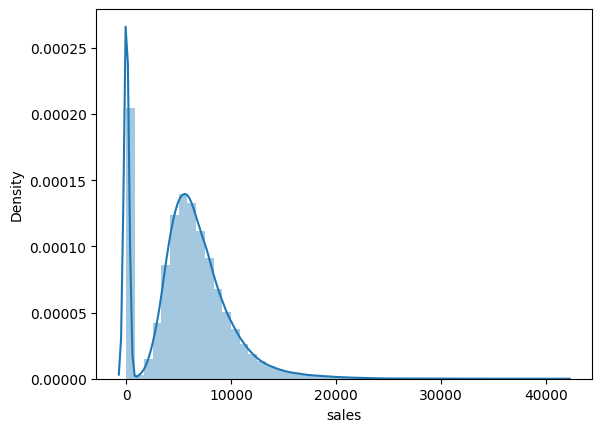

In [132]:
sns.distplot(df1['sales'])

C:\Users\Ian\AppData\Local\Temp\ipykernel_10040\3380288980.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df1['competition_distance'])


<Axes: xlabel='competition_distance', ylabel='Density'>

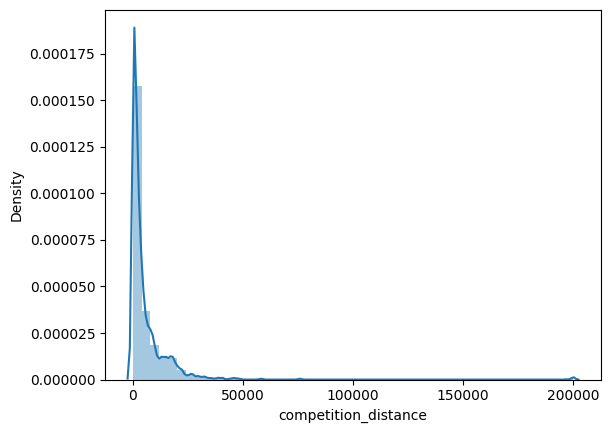

In [133]:
sns.distplot(df1['competition_distance'])

### 1.7.2 Cattegorical Attributes

In [134]:
cat_attributes.apply(lambda x: x.unique().shape[0])

state_holiday      4
store_type         4
assortment         3
promo_interval     4
month_map         12
dtype: int64

<Axes: xlabel='assortment', ylabel='sales'>

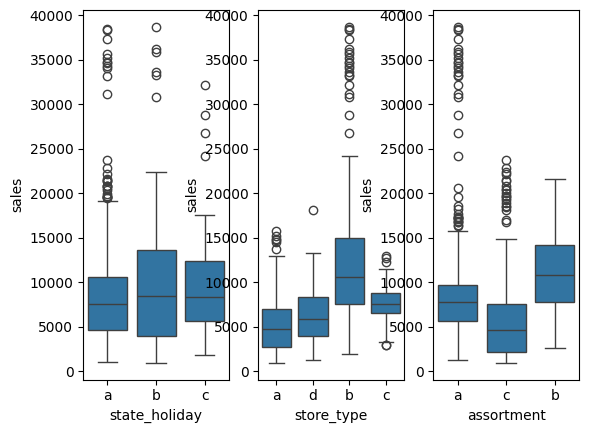

In [135]:
aux1 = df1[(df1['state_holiday'] != '0') & (df1['sales'] > 0)]

plt.subplot (1, 3, 1)
sns.boxplot( x='state_holiday', y= 'sales', data=aux1, legend=False)

plt.subplot(1, 3, 2)
sns.boxplot( x='store_type', y= 'sales', data=aux1, legend=False)

plt.subplot(1, 3, 3)
sns.boxplot( x='assortment', y= 'sales', data=aux1, legend=False)

# 2.0 Feature Engeneering

In [136]:
df2 = df1.copy()

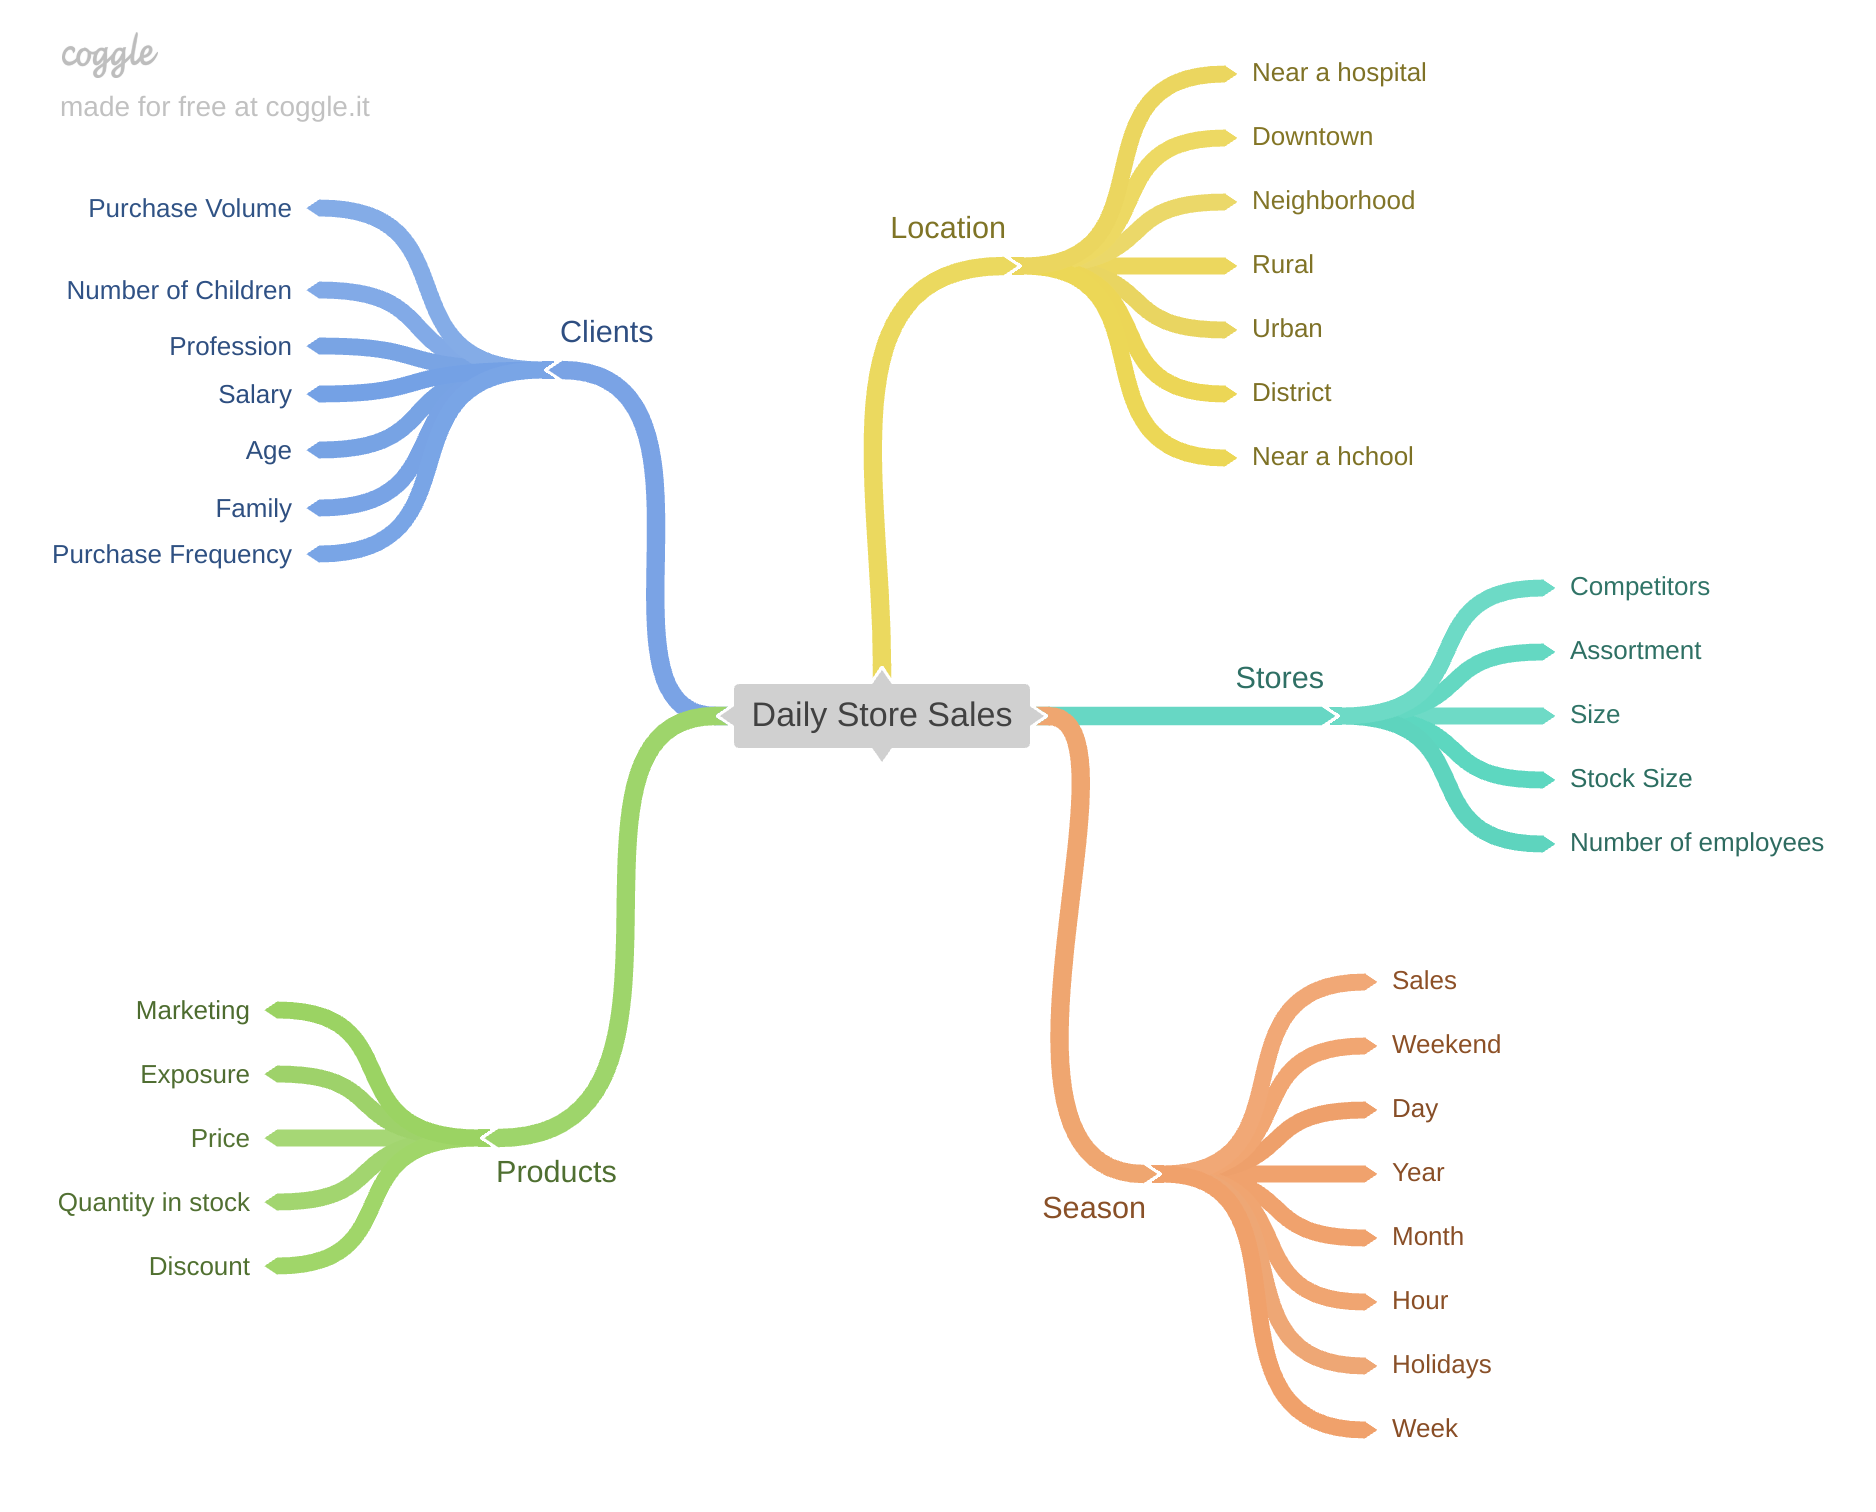

In [137]:
Image ('img/mind_map_hipotesis.png')

## 2.1 Criação de Hipoteses

### 2.1.1 Hipoteses Loja

**1.** Lojas com maior quadro de funcionarios deveriam vender mais.

**2.** Lojas com maior capacidade de estoque deveriam vender mais.

**3.** Lojas com maior porte deveriam vender mais.

**4.** Lojas com maior sortimento deveriam vender mais.

**5.** Lojas com competidores mais próximos deveriam vender menos.

**6.** Lojas com competidores à mais tempo deveriam vender mais.

### 2.1.2 Hipoteses Produto

**1.** Lojas que investem mais em Marketing deveriam vender mais.

**2.** Lojas que expoe mais o produto nas vitrines deveriam vender mais.

**3.** Lojas que tem preços menores nos produtos deveriam vender mais.

**4.** Lojas com promoções mais agressivas (descontos maiores) deveriam vender mais.

**5.** Lojas com promoções ativas por mais tempo deveriam vender mais.

**6.** Lojas com mais dias de promoção deveriam vender mais

**7.** Lojas qcom mais promoções consecutivas deveriam vender mais

### 2.1.3 Hipoteses Tempo (Sazonalidade)

**1.** Lojas abertas durante o feriado de Natal deveriam vender mais.

**2.** Lojas deveriam vender mais ao longo dos anos.

**3.** Lojas deveriam vender mais no segundo semestre do ano.

**4.** Lojas deveriam vender mais depois do dia 10 de cada mês.

**5.** Lojas deveriam vender menos aos finais de semana.

**6.** Lojas deveriam vender menos durantes os feriados escolares.

## 2.2 Lista Final de Hipóteses

**1.** Lojas com maior sortimento deveriam vender mais.

**2.** Lojas com competidores mais próximos deveriam vender menos.

**3.** Lojas com competidores à mais tempo deveriam vender mais.

**4.** Lojas com promoções ativas por mais tempo deveriam vender mais.

**5.** Lojas com mais dias de promoção deveriam vender mais.

**6.** Lojas com mais promoções consecutivas deveriam vender mais.

**7.** Lojas abertas durante o feriado de Natal deveriam vender mais.

**8.** Lojas deveriam vender mais ao longo dos anos.

**9.** Lojas deveriam vender mais no segundo semestre do ano.

**10.** Lojas deveriam vender mais depois do dia 10 de cada mês.

**11.** Lojas deveriam vender menos aos finais de semana.

**12.** Lojas deveriam vender menos durantes os feriados escolares.

## 2.3 Feature Engeneering

In [138]:
# year

df2['year'] = df2['date'].dt.year

# month

df2['month'] = df2['date'].dt.month

# day

df2['day'] = df2['date'].dt.day

# week of year

df2['week_of_year'] = df2['date'].dt.isocalendar().week

# year of week

df2['year_week'] = df2['date'].dt.strftime( '%Y-%W' )

# competition since

df2['competition_since'] = df2.apply(lambda x: datetime.datetime ( year=x['competition_open_since_year'], month=x['competition_open_since_month'], day=1) , axis= 1)
df2['competition_time_month'] = ((df2['date'] - df2[ 'competition_since'])/30).apply(lambda x: x.days).astype(int)

# promo since

df2['promo_since'] = df2['promo2_since_year'].astype(str) + '-' + df2['promo2_since_week'].astype(str)
df2['promo_since'] = df2['promo_since'].apply(lambda x: datetime.datetime.strptime( x + '-1', '%Y-%W-%w') - datetime.timedelta(days = 7))

df2['promo_time_week'] = ((df2['date'] - df2['promo_since'])/7).apply( lambda x: x.days).astype(int)

# assortment

df2['assortment'] = df2['assortment'].apply(lambda x: 'basic' if x == 'a' else 'extra' if x=='b' else 'extended')

# state holiday

df2['state_holiday'] = df2['state_holiday'].apply(lambda x: 'public_holiday' if x == 'a' else 'easter_holiday' if x=='b' else 'christmas' if x=='c' else 'regular_day')

In [139]:
df2.head().T

,0,1,2,3,4
store,1,2,3,4,5
day_of_week,5,5,5,5,5
date,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00
sales,5263,6064,8314,13995,4822
customers,555,625,821,1498,559
open,1,1,1,1,1
promo,1,1,1,1,1
state_holiday,regular_day,regular_day,regular_day,regular_day,regular_day
school_holiday,1,1,1,1,1
store_type,c,a,a,c,a


# 3.0 Filtragem de Variáveis

In [140]:
df3 = df2.copy()

In [141]:
df3.shape

(1017209, 29)

## 3.1 Filtragem das linhas

In [142]:
df3 = df3[(df3['open'] != 0) & (df3['sales'] > 0)]

## 3.2 Seleção das Colunas

In [143]:
cols_drop = ['customers', 'open', 'promo_interval', 'month_map']

df3 = df3.drop(cols_drop, axis=1)

In [144]:
df3.columns

Index(['store', 'day_of_week', 'date', 'sales', 'promo', 'state_holiday',
       'school_holiday', 'store_type', 'assortment', 'competition_distance',
       'competition_open_since_month', 'competition_open_since_year', 'promo2',
       'promo2_since_week', 'promo2_since_year', 'is_promo', 'year', 'month',
       'day', 'week_of_year', 'year_week', 'competition_since',
       'competition_time_month', 'promo_since', 'promo_time_week'],
      dtype='object')

# 4.0 Análise Exploratória dos Dados

In [145]:
df4 = df3.copy()

## 4.1 Análise Univariada

### 4.1.1 Response Variable

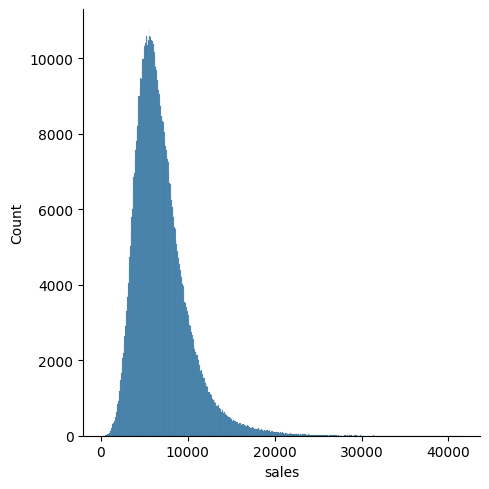

In [146]:
sns.displot (df4['sales'], kde=False)

### 4.1.2 Numerical Variables

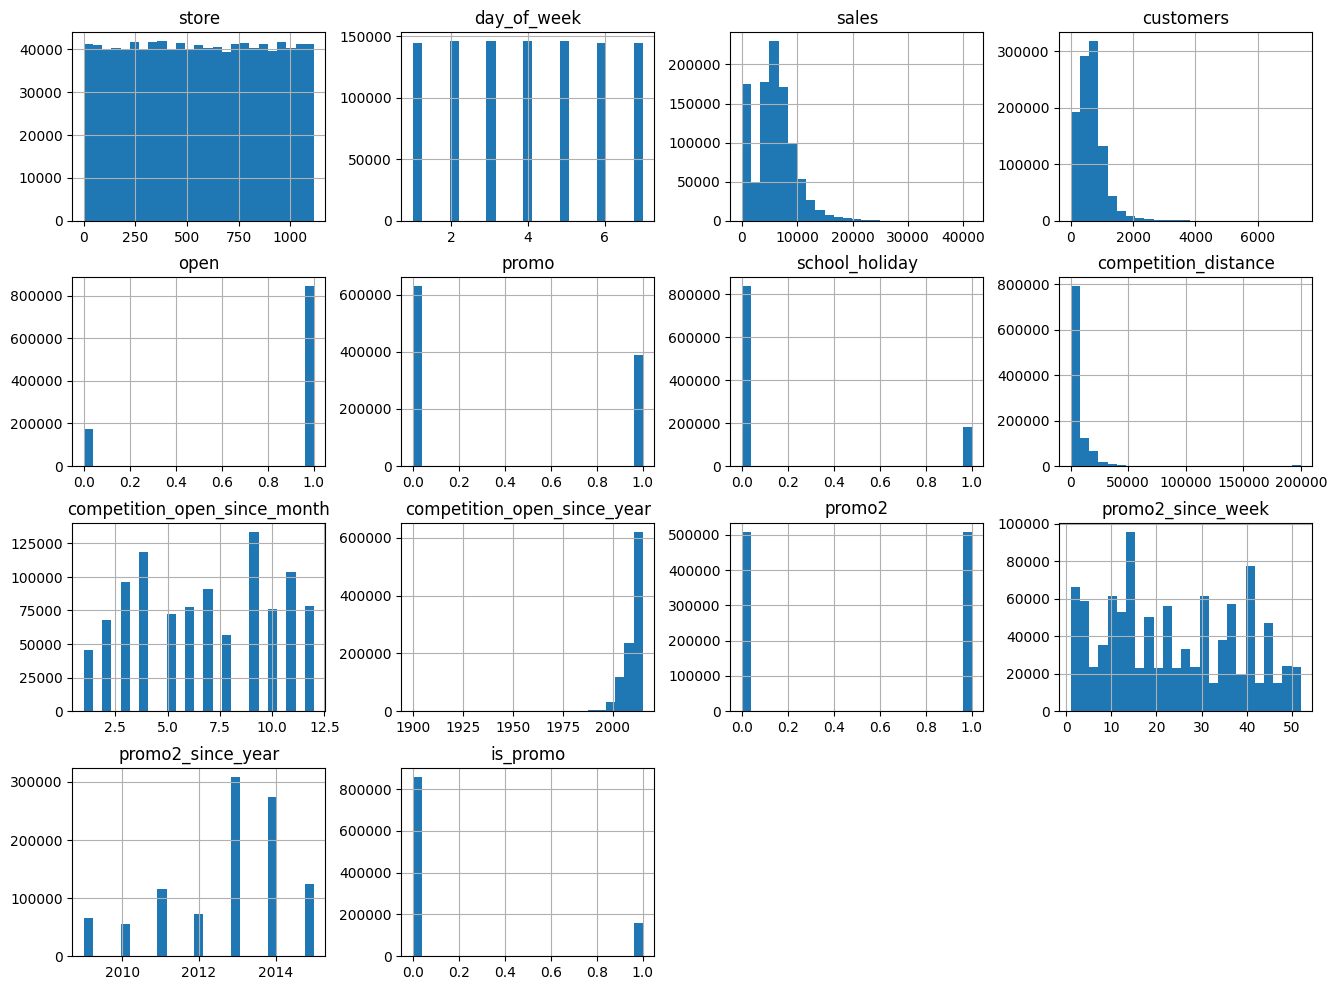

In [147]:
num_attributes.hist(bins= 25, figsize=(16,12));

### 4.1.3 Categorical Variable

In [148]:
df4['state_holiday'].drop_duplicates()

0            regular_day
63559     public_holiday
129424    easter_holiday
241126         christmas
Name: state_holiday, dtype: object

<Axes: xlabel='count', ylabel='state_holiday'>

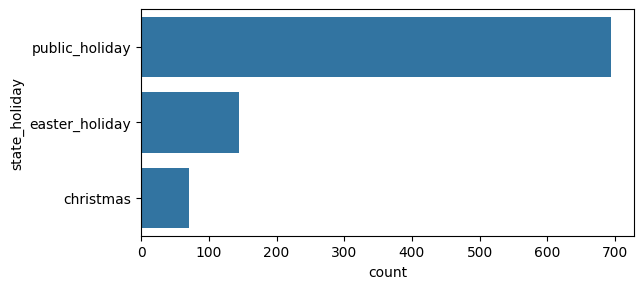

In [149]:
#state_holiday

plt.figure(figsize=(14,10))
plt.subplot(3,2,1)
a = df4[df4['state_holiday'] != 'regular_day']

sns.countplot (a['state_holiday'])

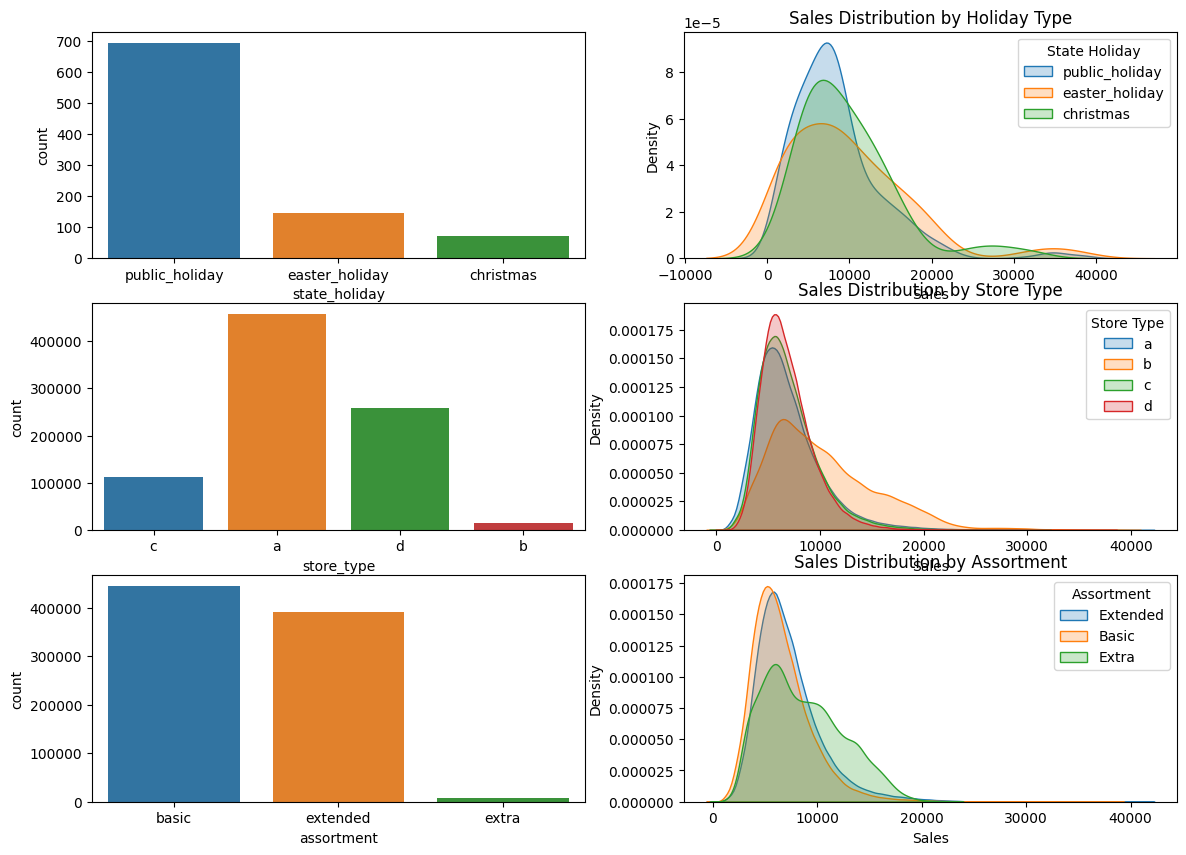

In [150]:
#state_holiday

plt.figure(figsize=(14,10))
plt.subplot(3,2,1)
a = df4[df4['state_holiday'] != 'regular_day']

sns.countplot (x=a['state_holiday'], hue=a['state_holiday'])

plt.subplot(3,2,2)
sns.kdeplot(x=df4[df4['state_holiday'] == 'public_holiday']['sales'], label='public_holiday', fill=True)

sns.kdeplot(x=df4[df4['state_holiday'] == 'easter_holiday']['sales'], label='easter_holiday', fill=True)

sns.kdeplot(x=df4[df4['state_holiday'] == 'christmas']['sales'], label='christmas', fill=True)
plt.xlabel("Sales")
plt.ylabel("Density")
plt.title("Sales Distribution by Holiday Type")
plt.legend(title="State Holiday")

#store_type

plt.subplot(3,2,3)
sns.countplot (x=df4['store_type'], hue=df4['store_type'])

plt.subplot(3,2,4)
sns.kdeplot(x=df4[df4['store_type'] == 'a']['sales'], label='a', fill=True)

sns.kdeplot(x=df4[df4['store_type'] == 'b']['sales'], label='b', fill=True)

sns.kdeplot(x=df4[df4['store_type'] == 'c']['sales'], label='c', fill=True)

sns.kdeplot(x=df4[df4['store_type'] == 'd']['sales'], label='d', fill=True)
plt.xlabel("Sales")
plt.ylabel("Density")
plt.title("Sales Distribution by Store Type")
plt.legend(title="Store Type")

#assortment

plt.subplot(3,2,5)
sns.countplot (x=df4['assortment'], hue=df4['assortment'])

plt.subplot(3,2,6)
sns.kdeplot(x=df4[df4['assortment'] == 'extended']['sales'], label='Extended', fill=True)

sns.kdeplot(x=df4[df4['assortment'] == 'basic']['sales'], label='Basic', fill=True)

sns.kdeplot(x=df4[df4['assortment'] == 'extra']['sales'], label='Extra', fill=True)

plt.xlabel("Sales")
plt.ylabel("Density")
plt.title("Sales Distribution by Assortment")
plt.legend(title="Assortment")


In [151]:
df4.columns

Index(['store', 'day_of_week', 'date', 'sales', 'promo', 'state_holiday',
       'school_holiday', 'store_type', 'assortment', 'competition_distance',
       'competition_open_since_month', 'competition_open_since_year', 'promo2',
       'promo2_since_week', 'promo2_since_year', 'is_promo', 'year', 'month',
       'day', 'week_of_year', 'year_week', 'competition_since',
       'competition_time_month', 'promo_since', 'promo_time_week'],
      dtype='object')

## 4.2 Análise Bivariada

<Axes: xlabel='year_week'>

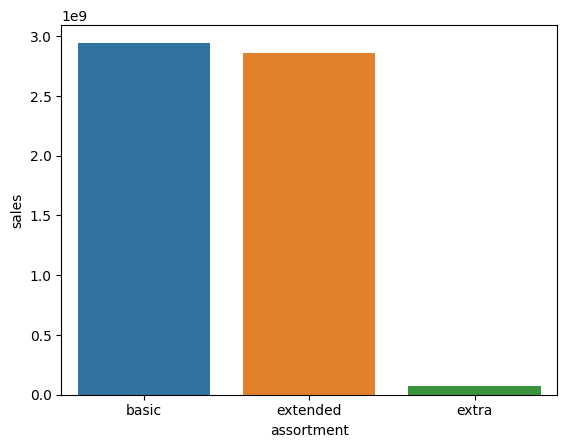

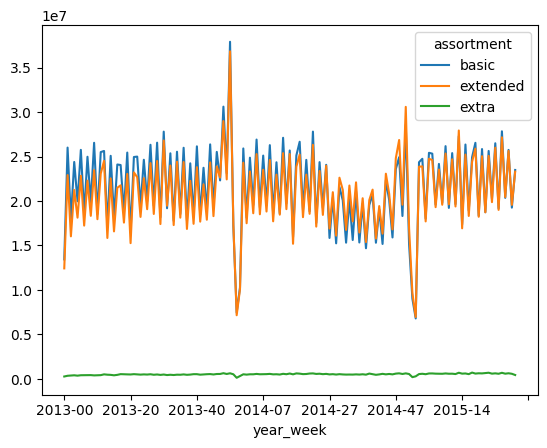

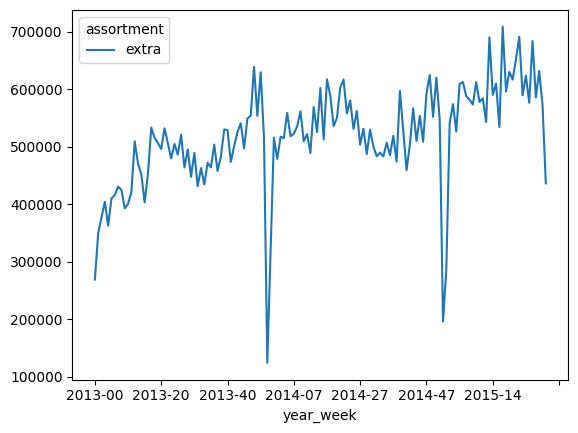

In [ ]:
# Lojas com maior sortimento deveriam vender mais.
# Falsa - Lojas ocm maior sortimento vendem menos

aux1 = df4[['assortment', 'sales']].groupby('assortment').sum().reset_index()


sns.barplot( x='assortment', y='sales', data=aux1, hue='assortment')

aux2 = df4[['year_week','assortment', 'sales']].groupby(['year_week', 'assortment']).sum().reset_index()
aux2.pivot(index='year_week', columns='assortment', values='sales').plot()

aux3 = aux2[aux2['assortment'] == 'extra']
aux3.pivot(index='year_week', columns='assortment', values='sales').plot()



C:\Users\Ian\AppData\Local\Temp\ipykernel_10040\2025289704.py:13: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  aux2 = aux1[['competition_distance_binned', 'sales']].groupby('competition_distance_binned').sum().reset_index()


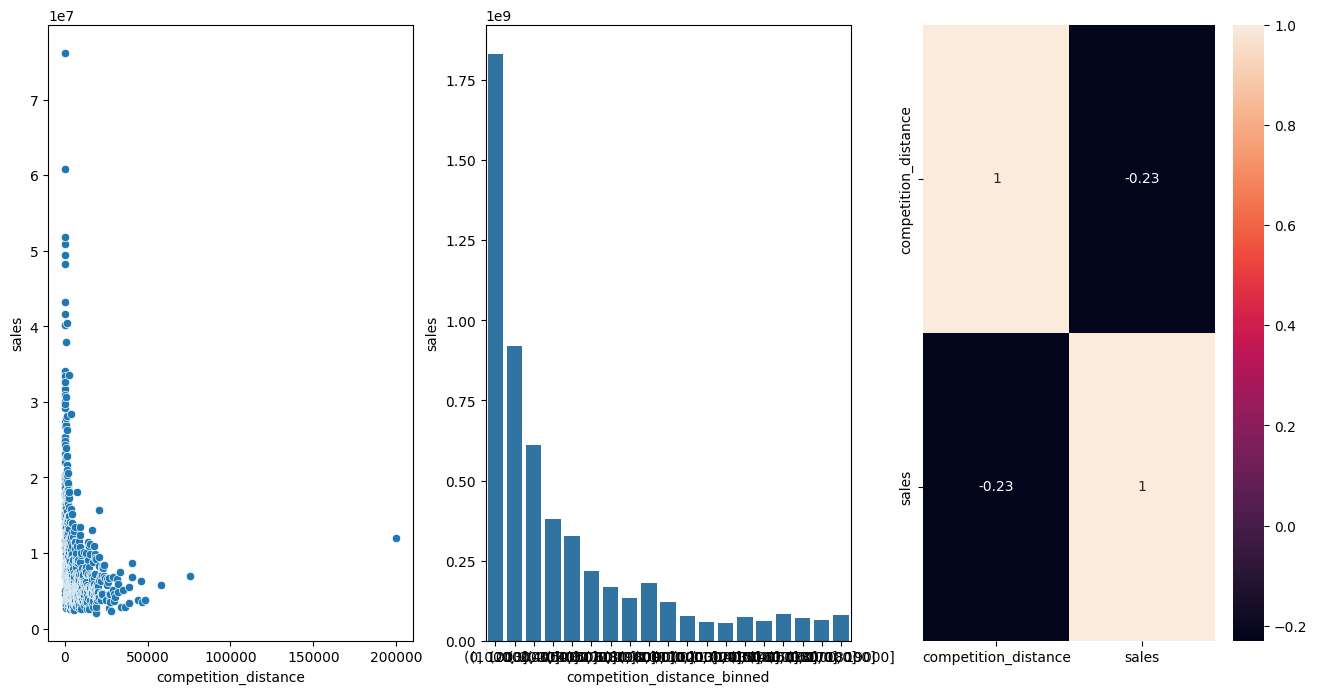

In [ ]:
# Lojas com competidores mais próximos deveriam vender menos
# Falsa Loja com competidores MAIS proximos vendem MAIS

aux1 = df4[['competition_distance', 'sales']].groupby('competition_distance').sum().reset_index()

plt.figure(figsize=(16,8))
plt.subplot(1,3,1)
sns.scatterplot(x = 'competition_distance', y='sales', data=aux1);

plt.subplot(1,3,2)
bins = list(np.arange(0,20000,1000))
aux1['competition_distance_binned'] = pd.cut( aux1['competition_distance'], bins=bins)
aux2 = aux1[['competition_distance_binned', 'sales']].groupby('competition_distance_binned').sum().reset_index()
sns.barplot(x='competition_distance_binned', y='sales', data=aux2);



plt.subplot(1,3,3)
aux3 = df4[['competition_distance', 'sales']].groupby('competition_distance').sum().reset_index()
sns.heatmap(aux3.corr(method='pearson'), annot=True);



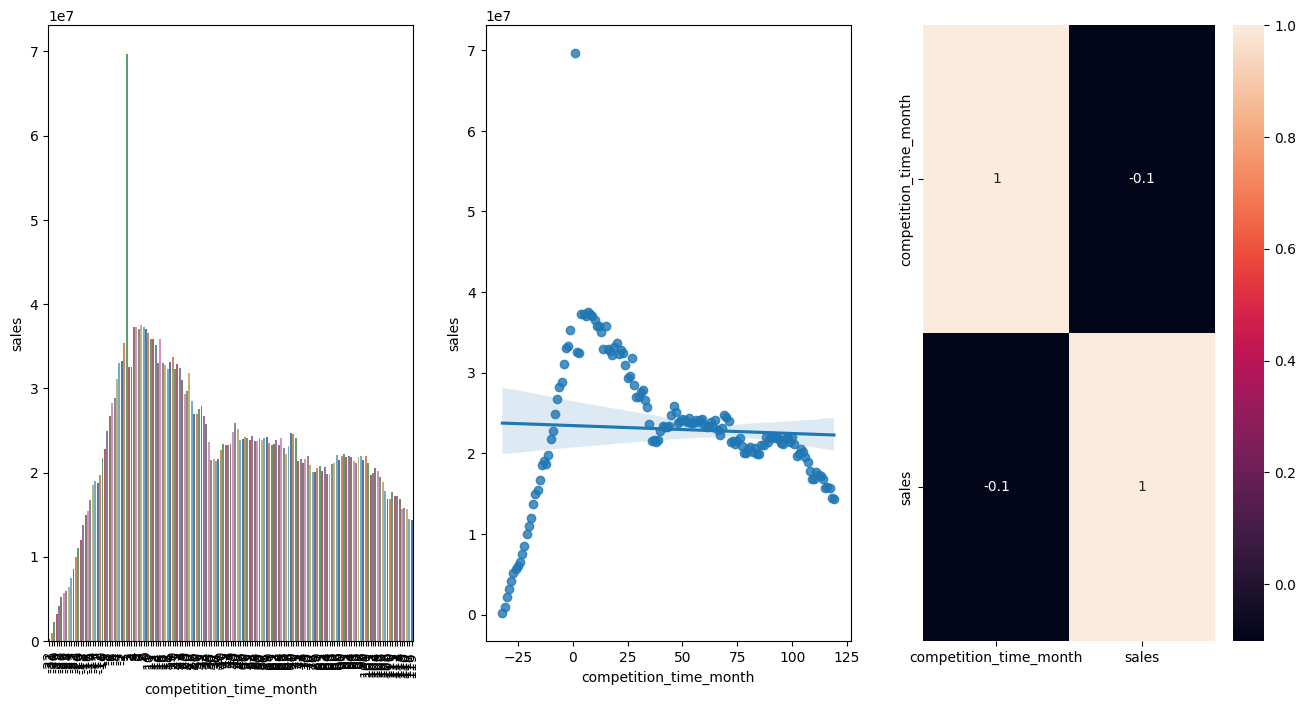

In [ ]:
#Lojas com competidores a mais tempo deveria vender mais
# Falsa Lojas com competidores à mais tempo vendem MENOS

plt.figure(figsize=(16,8))
plt.subplot(1,3,1)
aux1 = df4[['competition_time_month', 'sales']].groupby('competition_time_month').sum().reset_index()

aux2 = aux1[(aux1['competition_time_month'] < 120) & (aux1['competition_time_month'] !=0)]
sns.barplot( x='competition_time_month', y = 'sales', data=aux2, hue='competition_time_month', legend=False, palette='deep')
plt.xticks(rotation=90);


plt.subplot(1,3,2)
sns.regplot(x='competition_time_month', y='sales', data=aux2)

plt.subplot(1,3,3)
x = sns.heatmap( aux1.corr(method='pearson'), annot=True)


## 4.3 Análise Multivariada